In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
from PIL import Image
from random import randint

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# unzip
!unzip '/content/drive/MyDrive/CEP_DATA/archive.zip'

In [ ]:
import os
base_dir = "/content/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']


In [ ]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
def edge_detection(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  # Remove noise by blurring with a Gaussian filter
  img = cv2.GaussianBlur(img, (3, 3), 0)
  #For adaptive threshold values
  med_val = np.median(img)
  lower = int(max(0 ,0.7 * med_val))
  upper = int(min(255,1.3*med_val))
  canny_img = cv2.Canny(image=img, threshold1=lower, threshold2=upper)
  return cv2.cvtColor(canny_img,cv2.COLOR_GRAY2BGR)

def hist_equalization(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  enhanced_img = cv2.equalizeHist(img)
  return enhanced_img

def saliency(img):
  saliency = cv2.saliency.StaticSaliencyFineGrained_create()
  (success, saliencyMap) = saliency.computeSaliency(img)
  saliencyMap = (saliencyMap * 255).astype("uint8")
  return saliencyMap

In [ ]:
data_path = '/content/Alzheimer_s Dataset'
CLASSES = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]
def get_data(data_type="train", feature="edge"):
  data = []
  labels = []

  for dir in os.listdir(os.path.join(data_path, data_type)):
    for img_path in os.listdir(data_path+'/'+data_type+'/'+dir):
      pth = data_path+'/'+data_type+'/'+dir+'/'+img_path
      img = cv2.imread(pth)
      # apply feature extraction
      if feature == "edge":
        img = edge_detection(img)
      elif feature == "enhancement":
        img = hist_equalization(img)
      elif feature == "saliency":
        img = saliency(img)

      label = ''
      if dir == 'MildDemented':
        label = 0
      elif dir == 'ModerateDemented':
        label = 1
      elif dir == 'NonDemented':
        label = 2
      elif dir == 'VeryMildDemented':
        label = 3

      data.append(cv2.resize(img, (225,225)))
      labels.append(label)

  return data, labels

train_data, train_labels = get_data(data_type="train")
test_data, test_labels = get_data(data_type="test")

In [ ]:
print(len(train_data))

5121


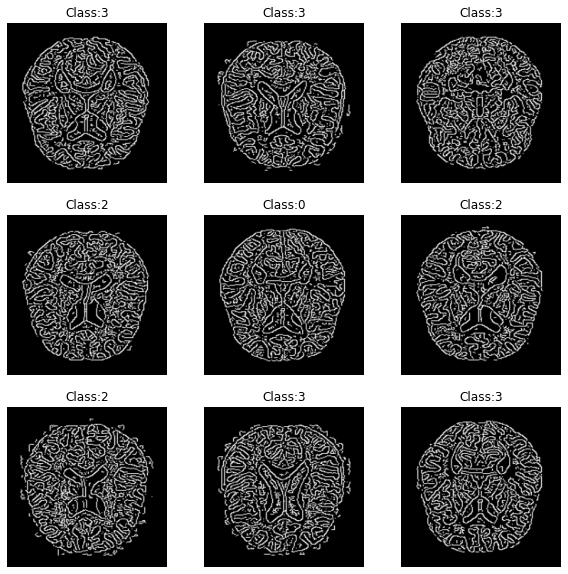

In [ ]:
def show_images(y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =train_labels
    
    # get a batch of images
    #x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 5121)
            plt.imshow(train_data[idx], cmap='gray', vmin=0, vmax=255)
            plt.axis("off")
            plt.title("Class:{}".format(labels[idx]))
                                                     
    # else:
    #     for i in range(9):
    #         ax = plt.subplot(3, 3, i + 1)
    #         plt.imshow(x[i])
    #         plt.axis("off")
    #         plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images()

In [ ]:
# #Performing Image Augmentation to have more data samples
# from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
# ZOOM = [.99, 1.01]
# BRIGHT_RANGE = [0.8, 1.2]
# HORZ_FLIP = True
# FILL_MODE = "constant"
# DATA_FORMAT = "channels_last"

# work_dr = IDG(rescale = 1./255, preprocessing_function = edge_detection)

# train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6400, shuffle=False)

Found 6400 images belonging to 4 classes.


In [ ]:
# #Retrieving the data from the ImageDataGenerator iterator

# train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting to know the dimensions of our dataset

# print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
train_data = np.array(train_data)
test_data = np.array(test_data)

train_labels = tf.keras.utils.to_categorical(train_labels , num_classes=4)
test_labels = tf.keras.utils.to_categorical(test_labels , num_classes=4)

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(5121, 225, 225)
(5121, 4)
(1279, 225, 225)
(1279, 4)


In [ ]:
# #Splitting the data into train, test, and validation sets
# from sklearn.model_selection import train_test_split


# train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
# train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
base_model = DenseNet121(input_shape=(225,225,1), 
                         include_top=False,
                         weights=None)

In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 1024)        0         
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_12 (Bat  (None, 50176)            200704    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 1024)              51381248  
                                                                 
 batch_normalization_13 (Bat  (None, 1024)             4096      
 chNormalization)                                     

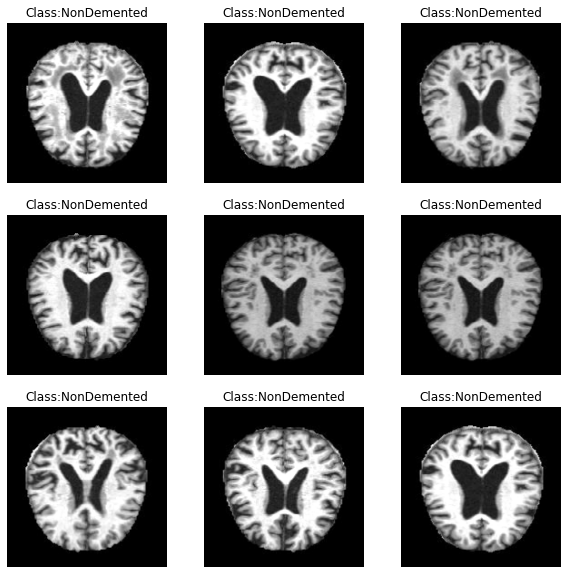

In [ ]:
import matplotlib.pyplot as plt
from random import randint, random
import numpy as np
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 31)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [ ]:
import tensorflow as tf

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
]

OPT    = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=EPOCHS)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


161/161 [==============================] - 82s 492ms/step - loss: 1.3059 - accuracy: 0.7519 - auc: 0.7724 - val_loss: 1.1914 - val_accuracy: 0.7721 - val_auc: 0.8225
Epoch 2/50
161/161 [==============================] - 78s 486ms/step - loss: 1.0017 - accuracy: 0.7893 - auc: 0.8325 - val_loss: 1.2680 - val_accuracy: 0.7236 - val_auc: 0.7441
Epoch 3/50
161/161 [==============================] - 78s 487ms/step - loss: 0.8972 - accuracy: 0.8110 - auc: 0.8610 - val_loss: 1.2359 - val_accuracy: 0.7719 - val_auc: 0.8147
Epoch 4/50
161/161 [==============================] - 74s 457ms/step - loss: 0.8325 - accuracy: 0.8218 - auc: 0.8776 - val_loss: 1.3657 - val_accuracy: 0.7635 - val_auc: 0.8203
Epoch 5/50
161/161 [==============================] - 78s 484ms/step - loss: 0.7917 - accuracy: 0.8315 - auc: 0.8892 - val_loss: 1.3535 - val_accuracy: 0.7504 - val_auc: 0.7960
Epoch 6/50
161/161 [==============================] - 73s 456ms/step - loss: 0.7288 - accuracy: 0.8426 - auc: 0.9040 - val_los

In [ ]:
hist_df = pd.DataFrame(history.history) 
modelName="densenet121edge_history"
hist_df.to_csv("/content/drive/MyDrive/CEP_DATA/models history/"+modelName+".csv")

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter( y=history.history['val_loss'], name="val_loss"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter( y=history.history['loss'], name="loss"),
#     secondary_y=False,
# )

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="train accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Accuracy of Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text="Loss of Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
pred_labels = model.predict(test_data)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
print(labels)
print(classification_report(test_labels, pred_labels, target_names=CLASSES))

from sklearn.metrics import roc_auc_score
print("Accuracy is",roc_auc_score(test_labels, pred_labels))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



[1. 0. 0. 0.]
                  precision    recall  f1-score   support

    MildDemented       0.69      0.06      0.11       179
ModerateDemented       1.00      0.08      0.15        12
     NonDemented       0.61      0.79      0.69       640
VeryMildDemented       0.51      0.48      0.49       448

       micro avg       0.57      0.57      0.57      1279
       macro avg       0.70      0.35      0.36      1279
    weighted avg       0.59      0.57      0.53      1279
     samples avg       0.57      0.57      0.57      1279

Accuracy is 0.5810486229320264


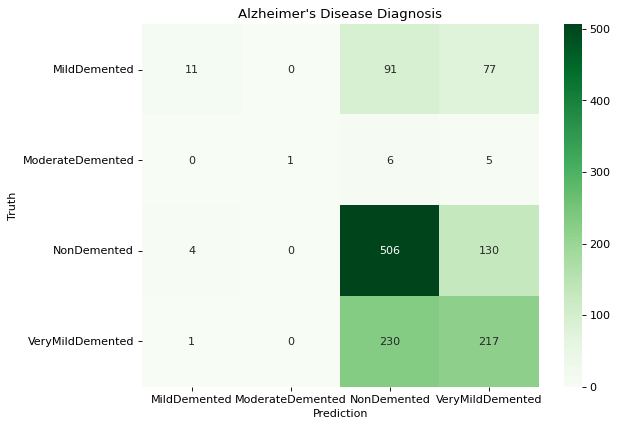

In [ ]:
#Plot the confusion matrix to understand the classification in detail
import seaborn as sns
import matplotlib.pyplot as plt

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)